In [138]:
#pip install datasets
#pip install keybert

In [1]:
import pandas as pd
import json
import datasets
from datasets import load_dataset

In [2]:
# get the dataset only for keyphrase generation
dataset = load_dataset("midas/duc2001", "generation")

print("Samples for Keyphrase Generation")

# sample from the test split
print("Sample from test data split")
test_sample = dataset["test"][0]
print("Fields in the sample: ", [key for key in test_sample.keys()])
print("Tokenized Document: ", test_sample["document"])
print("Extractive/present Keyphrases: ", test_sample["extractive_keyphrases"])
print("Abstractive/absent Keyphrases: ", test_sample["abstractive_keyphrases"])
print("\n-----------\n")

Found cached dataset duc2001 (C:/Users/Alicia/.cache/huggingface/datasets/midas___duc2001/generation/0.0.1/7888b46165d8a58f49f00e28410b46b1f22fabfd72a9e89f3e80a4e2d27e4a9b)


  0%|          | 0/1 [00:00<?, ?it/s]

Samples for Keyphrase Generation
Sample from test data split
Fields in the sample:  ['id', 'document', 'extractive_keyphrases', 'abstractive_keyphrases']
Tokenized Document:  ['Here', ',', 'at', 'a', 'glance', ',', 'are', 'developments', 'today', 'involving', 'the', 'crash', 'of', 'Pan', 'American', 'World', 'Airways', 'Flight', '103', 'Wednesday', 'night', 'in', 'Lockerbie', ',', 'Scotland', ',', 'that', 'killed', 'all', '259', 'people', 'aboard', 'and', 'more', 'than', '20', 'people', 'on', 'the', 'ground', ':']
Extractive/present Keyphrases:  ['pan american world airways flight 103', 'crash', 'lockerbie']
Abstractive/absent Keyphrases:  ['terrorist threats', 'widespread wreckage', 'radical palestinian faction', 'terrorist bombing', 'bomb threat', 'sabotage']

-----------



In [3]:
def drop_column(dataset):
    del dataset['abstractive_keyphrases']
    return dataset

# Para eliminar la columna que no necesitamos
dataset = dataset.map(drop_column)

Loading cached processed dataset at C:\Users\Alicia\.cache\huggingface\datasets\midas___duc2001\generation\0.0.1\7888b46165d8a58f49f00e28410b46b1f22fabfd72a9e89f3e80a4e2d27e4a9b\cache-16ebf8679ee254b4.arrow


Hasta aquí tenemos un dataset con las 3 columnas de interés:

In [4]:
dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'document', 'extractive_keyphrases'],
        num_rows: 308
    })
})

In [5]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alicia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alicia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

A continuación juntamos las palabras de 'document' porque estan separadas por comas, y para cada texto resultante implementamos keybert. Guardamos las keywords de cada texto y los scores

In [6]:
from keybert import KeyBERT
kw_model = KeyBERT()

In [7]:
keywords = []
scores = []  

for i in range(len(dataset['test'])):
    joined_text = " ".join(dataset['test'][i]['document'])
    keywords_row = []
    score_row = []  
    for keyword_info in kw_model.extract_keywords(joined_text, keyphrase_ngram_range=(1, 2), stop_words=None, use_maxsum=True, 
                                                  nr_candidates=20, top_n=20, diversity=0.7):
        keyword, score = keyword_info  # extraer palabra clave y puntuación
        keywords_row.append(keyword) 
        score_row.append(score) 
    keywords.append(keywords_row)
    scores.append(score_row)  


In [29]:
import itertools
scores_list = list(itertools.chain.from_iterable(scores))

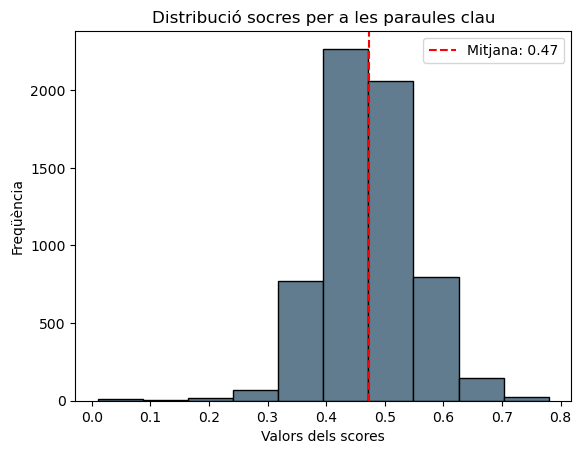

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Crear histograma
plt.hist(scores_list, edgecolor='black', color='#607c8e')

# Calcular la media
mean_value = np.mean(scores_list)

# Agregar línea vertical para la media
plt.axvline(x=mean_value, color='red', linestyle='--', label=f'Mitjana: {mean_value:.2f}')

# Agregar título y etiquetas de eje
plt.title('Distribució socres per a les paraules clau')
plt.xlabel('Valors dels scores')
plt.ylabel('Freqüència')

# Agregar leyenda
plt.legend()

# Mostrar el histograma
plt.show()

In [8]:
scores[0]

[0.2311,
 0.2419,
 0.2471,
 0.2732,
 0.2766,
 0.2785,
 0.2805,
 0.2887,
 0.306,
 0.3078,
 0.3198,
 0.3353,
 0.3371,
 0.3799,
 0.4006,
 0.4154,
 0.4203,
 0.4206,
 0.4259,
 0.4514]

In [9]:
keywords[0] #prueba

['aboard and',
 'people',
 'lockerbie scotland',
 'american world',
 'killed',
 'all 259',
 '259',
 'pan american',
 '20 people',
 'airways',
 'people aboard',
 'flight',
 'killed all',
 'crash',
 'crash of',
 'airways flight',
 '259 people',
 'world airways',
 'the crash',
 'flight 103']

A continuación sacamos las categorias gramaticales de cada keyword/keyphrase:

In [10]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag

keyphrases_pos = []

for keyword_list in keywords:
    sublist_keyphrases_pos = []
    for keyword in keyword_list:
        palabras = word_tokenize(keyword)
        etiquetas = pos_tag(palabras)
        sublist_keyphrases_pos.append(etiquetas)
    keyphrases_pos.append(sublist_keyphrases_pos)

print(keyphrases_pos[0])

[[('aboard', 'NN'), ('and', 'CC')], [('people', 'NNS')], [('lockerbie', 'NN'), ('scotland', 'NN')], [('american', 'JJ'), ('world', 'NN')], [('killed', 'VBN')], [('all', 'DT'), ('259', 'CD')], [('259', 'CD')], [('pan', 'NNS'), ('american', 'VBP')], [('20', 'CD'), ('people', 'NNS')], [('airways', 'NNS')], [('people', 'NNS'), ('aboard', 'VBP')], [('flight', 'NN')], [('killed', 'VBN'), ('all', 'DT')], [('crash', 'NN')], [('crash', 'NN'), ('of', 'IN')], [('airways', 'NNS'), ('flight', 'NN')], [('259', 'CD'), ('people', 'NNS')], [('world', 'NN'), ('airways', 'NNS')], [('the', 'DT'), ('crash', 'NN')], [('flight', 'NN'), ('103', 'CD')]]


In [11]:
print(len(keyphrases_pos[0][0])) # aboard and
print(len(keyphrases_pos[0][1])) # people

print(len(keyphrases_pos[0])) # las 20 keywords/keyphrases del doc 0

2
1
20


In [12]:
len(keyphrases_pos) # Seguimos teniendo 308 sublistas (una para cada doc)

308

Quitamos las que tienen una combinación diferente a las que nos interesan:  INTERÉS: adj + noun  /  noun + noun  TAMBIÉN  nos quedamos con las de long 1

In [13]:
valid_combinations = [('JJ', 'NN'), ('JJ', 'NNS'), ('JJ', 'NNP'), ('JJ', 'NNPS'), 
                      ('JJR', 'NN'), ('JJR', 'NNS'), ('JJR', 'NNP'), ('JJR', 'NNPS'),
                      ('JJS', 'NN'), ('JJS', 'NNS'), ('JJS', 'NNP'), ('JJS', 'NNPS'),
                      ('NN', 'NN'), ('NNS', 'NN'), ('NNP', 'NN'), ('NNPS', 'NN'), 
                      ('NN', 'NNS'), ('NNS', 'NNS'), ('NNP', 'NNS'), ('NNPS', 'NNS'),
                      ('NN', 'NNP'), ('NNS', 'NNP'), ('NNP', 'NNP'), ('NNPS', 'NNP'),
                      ('NN', 'NNPS'), ('NNS', 'NNPS'), ('NNP', 'NNPS'), ('NNPS', 'NNPS')]

for i in range(len(keyphrases_pos)):
    for j in range(len(keyphrases_pos[i])):
        if isinstance(keyphrases_pos[i][j], list):
            for k in range(len(keyphrases_pos[i][j]) - 1):
                if (keyphrases_pos[i][j][k][1], keyphrases_pos[i][j][k+1][1]) not in valid_combinations:
                    keyphrases_pos[i][j] = []
                    break
        else:
            if (keyphrases_pos[i][j][1],) not in valid_combinations:
                keyphrases_pos[i][j] = []


print(keyphrases_pos[0]) # entonces ahora ya sólo tenemos guardadas las kephrases que su POS tag nos interesa (los que indicaban el paper aquel en el pie de letra pág. 4) Y las de longitud 1


[[], [('people', 'NNS')], [('lockerbie', 'NN'), ('scotland', 'NN')], [('american', 'JJ'), ('world', 'NN')], [('killed', 'VBN')], [], [('259', 'CD')], [], [], [('airways', 'NNS')], [], [('flight', 'NN')], [], [('crash', 'NN')], [], [('airways', 'NNS'), ('flight', 'NN')], [], [('world', 'NN'), ('airways', 'NNS')], [], []]


In [14]:
len(keyphrases_pos)

308

#######################################################################################################################################################################################

Ahora calcularemos la precisión i eel recall para cada texto, para ello necesitamos saber cuántas extractive_keyphrases tiene cada uno, cuántas keyphrsases obtenidas con keybert tiene cada uno, y cuántas de estas coinciden con las keyphrases obtenidas con KeyBERT y el filtraje hecho con POS

Juntamos las extractive keyphrases en una lista, ya que están separadas en el dataset

In [15]:
# Crear una lista de sublistas
extractive_keyphrases_list = []

for element in dataset['test']:
    # Acceder a la lista de extractive_keyphrases para cada elemento
    extractive_keyphrases = element['extractive_keyphrases']
    
    # Añadir la lista de extractive_keyphrases a la lista de sublistas
    extractive_keyphrases_list.append(extractive_keyphrases)
    
print(len(extractive_keyphrases_list))
print(extractive_keyphrases_list)

308
[['pan american world airways flight 103', 'crash', 'lockerbie'], ['tornado season', 'spring thunderstorms', 'tornadoes', 'texas', 'property damage', 'tornado warning', 'tornado watches', 'disaster research'], ['crashes', 'pilots', 'bodenheim', 'training mission', 'aircraft'], ['forest fire policy', 'western fire season', 'national forests', 'fire management plans', 'natural fires', 'recommended halt', 'panel'], ['forest fires', 'criminal investigator', 'investigations', 'passing truck', 'missouri', 'arsonist', 'arson problem'], ['welfare reform', 'president reagan', 'welfare legislation', 'work requirement', 'welfare programs', 'unemployment', 'americans'], ['crash', 'training flight', 'crew members', 'pilot'], ['de beers diamond organization', 'fair trading', 'south africa', 'world diamond trading', 'defensive move', 'central selling organization', 'investigation'], ['deadening drought', 'annual agriculture department survey', 'fall corn harvest', 'higher retail food prices', 'pr

In [16]:
# guardar el numero de extractive keyphrases que hay para cada doc (esto es necesario para luego calcular la precisión)

n_extractive_keyphrases = []
for sublista in extractive_keyphrases_list:
    num_elementos = len(sublista)
    n_extractive_keyphrases.append(num_elementos)

print(n_extractive_keyphrases)

[3, 8, 5, 7, 7, 7, 4, 7, 9, 6, 7, 8, 6, 5, 7, 10, 7, 7, 5, 5, 8, 7, 8, 6, 7, 8, 6, 6, 2, 5, 7, 8, 8, 8, 8, 8, 8, 6, 7, 9, 8, 9, 8, 5, 7, 8, 5, 8, 7, 8, 12, 7, 5, 10, 10, 6, 10, 7, 4, 10, 7, 8, 8, 7, 10, 4, 3, 10, 7, 9, 6, 6, 5, 6, 6, 6, 7, 8, 6, 2, 9, 7, 6, 6, 7, 7, 3, 6, 6, 8, 6, 6, 4, 7, 8, 6, 6, 9, 7, 6, 7, 5, 6, 8, 5, 6, 4, 6, 7, 10, 6, 8, 7, 7, 9, 8, 6, 8, 3, 10, 7, 8, 4, 7, 12, 9, 9, 7, 7, 5, 10, 9, 6, 10, 7, 11, 4, 6, 11, 8, 13, 8, 10, 7, 8, 7, 9, 8, 11, 7, 7, 6, 6, 5, 5, 13, 6, 8, 4, 9, 8, 6, 8, 8, 12, 10, 9, 6, 7, 7, 10, 6, 4, 7, 8, 6, 11, 8, 8, 5, 5, 7, 9, 7, 7, 6, 8, 6, 9, 5, 8, 11, 8, 6, 9, 11, 10, 7, 7, 7, 7, 9, 7, 7, 8, 11, 7, 7, 7, 6, 8, 6, 5, 7, 7, 11, 9, 9, 8, 7, 7, 7, 8, 9, 8, 5, 6, 7, 6, 10, 4, 11, 7, 6, 8, 9, 4, 7, 5, 8, 11, 6, 6, 9, 5, 10, 5, 7, 8, 6, 6, 5, 7, 6, 6, 8, 6, 7, 9, 10, 7, 4, 5, 4, 10, 3, 6, 6, 5, 9, 7, 7, 7, 7, 7, 7, 7, 7, 8, 6, 6, 10, 6, 6, 10, 6, 6, 12, 7, 8, 8, 8, 7, 6, 5, 5, 7, 5, 9, 5, 7, 5, 6, 5, 6, 7, 7, 6]


Ahora vamos a tener que juntar las keyphrases de la lista keyphrases_pos (tmbn de long = 308) para luego ver para cada sublista de esta lista los matches con cada sublista de las extractive_keyphrases_list

In [17]:
keyphrases_pos_list = []
for i in range(len(keyphrases_pos)):
    temp = []
    for j in range(len(keyphrases_pos[i])):
        if isinstance(keyphrases_pos[i][j], list):
            temp.append(keyphrases_pos[i][j])
        else:
            for k in range(len(keyphrases_pos[i][j])-1):
                if (keyphrases_pos[i][j][k][1], keyphrases_pos[i][j][k+1][1]) in valid_combinations:
                    temp.append(keyphrases_pos[i][j][k][0] + ' ' + keyphrases_pos[i][j][k+1][0])
    keyphrases_pos_list.append(temp)

print(len(keyphrases_pos_list))
print(keyphrases_pos_list)


308
[[[], [('people', 'NNS')], [('lockerbie', 'NN'), ('scotland', 'NN')], [('american', 'JJ'), ('world', 'NN')], [('killed', 'VBN')], [], [('259', 'CD')], [], [], [('airways', 'NNS')], [], [('flight', 'NN')], [], [('crash', 'NN')], [], [('airways', 'NNS'), ('flight', 'NN')], [], [('world', 'NN'), ('airways', 'NNS')], [], []], [[('damage', 'NN'), ('tornado', 'NN')], [], [('other', 'JJ'), ('tornado', 'NN')], [], [('tornado', 'NN'), ('warning', 'NN')], [], [('unofficial', 'JJ'), ('tornado', 'NN')], [('outrun', 'NN'), ('tornadoes', 'NNS')], [('coast', 'NN'), ('tornado', 'NN')], [('tornado', 'NN'), ('watches', 'NNS')], [], [], [], [('tornado', 'NN'), ('warnings', 'NNS')], [('tornado', 'NN')], [('tornadoes', 'NNS')], [], [], [], [('tornado', 'NN'), ('season', 'NN')]], [[], [], [], [], [], [], [], [], [('other', 'JJ'), ('pilot', 'NN')], [], [('fighter', 'NN'), ('jets', 'NNS')], [('pilots', 'NNS')], [], [], [], [], [], [], [('flight', 'NN'), ('crash', 'NN')], []], [[], [], [], [], [('fires', '

In [20]:
#NEW NEW NEW # guardar el numero de  keyphrases extraidas con keybert que hay para cada doc (esto es necesario para luego calcular la precisión)

n_keybert_keyphrases = []
for sublista in keyphrases_pos_list:
    num_elementos = len([x for x in sublista if x != []])
    n_keybert_keyphrases.append(num_elementos)

print(n_keybert_keyphrases)
print(len(n_keybert_keyphrases))


[10, 11, 4, 11, 12, 11, 1, 14, 17, 4, 6, 7, 13, 4, 10, 10, 10, 9, 12, 6, 10, 11, 12, 6, 11, 12, 10, 11, 14, 11, 9, 11, 7, 8, 4, 8, 10, 9, 7, 12, 11, 16, 14, 10, 6, 10, 8, 12, 10, 11, 13, 12, 10, 9, 16, 8, 14, 9, 8, 12, 12, 12, 12, 11, 8, 12, 7, 11, 11, 12, 9, 9, 13, 12, 9, 8, 12, 8, 9, 10, 11, 12, 12, 10, 11, 6, 9, 8, 11, 11, 14, 7, 9, 11, 9, 10, 11, 8, 8, 8, 10, 17, 8, 9, 11, 12, 14, 5, 18, 8, 12, 11, 13, 12, 15, 11, 9, 11, 15, 16, 9, 9, 12, 11, 11, 10, 17, 10, 8, 11, 13, 10, 9, 13, 11, 11, 13, 11, 7, 11, 5, 11, 11, 9, 14, 11, 12, 12, 13, 11, 5, 13, 11, 12, 12, 13, 12, 11, 10, 8, 8, 6, 17, 11, 12, 10, 15, 10, 15, 10, 10, 15, 15, 11, 10, 12, 9, 13, 15, 15, 8, 8, 9, 5, 12, 10, 10, 9, 11, 15, 4, 17, 7, 10, 12, 15, 11, 6, 12, 9, 9, 13, 17, 7, 6, 8, 16, 8, 8, 11, 11, 10, 11, 10, 12, 10, 7, 10, 11, 14, 9, 10, 8, 11, 14, 13, 14, 10, 10, 14, 13, 14, 8, 11, 12, 12, 9, 12, 10, 11, 15, 11, 11, 15, 10, 9, 8, 7, 11, 11, 9, 13, 8, 14, 10, 13, 11, 9, 10, 9, 9, 9, 10, 11, 5, 9, 8, 8, 9, 7, 11, 12, 14

In [21]:
sum(n_keybert_keyphrases) / len(n_keybert_keyphrases)  # media de keyphrases extraidas por keybert para cada doc

10.483766233766234

In [22]:

keybert_list = []
for sublista in keyphrases_pos_list:
    temp = []
    for elemento in sublista:
        if elemento:
            palabras = ' '.join([palabra[0] for palabra in elemento])
            temp.append(palabras)
    keybert_list.append(temp)
    
print(keybert_list)
print(len(keybert_list))

[['people', 'lockerbie scotland', 'american world', 'killed', '259', 'airways', 'flight', 'crash', 'airways flight', 'world airways'], ['damage tornado', 'other tornado', 'tornado warning', 'unofficial tornado', 'outrun tornadoes', 'coast tornado', 'tornado watches', 'tornado warnings', 'tornado', 'tornadoes', 'tornado season'], ['other pilot', 'fighter jets', 'pilots', 'flight crash'], ['fires', 'government fire', 'burn policy', 'fire management', 'fire renews', 'fire season', 'natural fire', 'forest fire', 'western fire', 'natural fires', 'fire policy'], ['fires', 'fires cost', 'arson case', 'twain fires', 'arson', 'arson subsistence', 'forest fire', 'fire smallwood', 'arson fire', 'arson problem', 'forest fires', 'smallwood fires'], ['widespread welfare', 'true welfare', 'welfare officials', 'welfare', 'welfare rolls', 'welfare programs', 'welfare trap', 'welfare recipients', 'welfare reform', 'welfare legislation', 'make welfare'], ['landings'], ['mining concern', 'african company'

In [23]:
#ir viendo los matches
print(extractive_keyphrases_list[0])
print(keybert_list[0])

['pan american world airways flight 103', 'crash', 'lockerbie']
['people', 'lockerbie scotland', 'american world', 'killed', '259', 'airways', 'flight', 'crash', 'airways flight', 'world airways']


Miramos los matches para cada doc

In [24]:
n_matches = []
for sub1, sub2 in zip(keybert_list, extractive_keyphrases_list):
    contador = 0
    for elem in sub1:
        if elem in sub2:
            contador += 1
    n_matches.append(contador)

print(len(n_matches))
print(n_matches)


308
[1, 4, 1, 1, 2, 3, 0, 0, 0, 0, 0, 3, 1, 1, 3, 2, 3, 2, 2, 0, 2, 2, 1, 3, 1, 3, 0, 3, 1, 1, 4, 1, 0, 2, 0, 1, 2, 1, 0, 3, 2, 2, 3, 4, 2, 2, 2, 2, 0, 2, 3, 0, 1, 1, 5, 2, 3, 1, 2, 4, 2, 2, 2, 2, 0, 3, 2, 3, 3, 4, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 6, 3, 3, 2, 4, 1, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 1, 2, 1, 1, 1, 4, 2, 0, 1, 1, 2, 0, 1, 3, 3, 1, 3, 2, 0, 2, 2, 0, 0, 4, 1, 4, 1, 1, 2, 2, 1, 2, 2, 4, 2, 1, 2, 2, 3, 2, 0, 2, 1, 2, 1, 4, 0, 0, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 3, 2, 0, 1, 3, 0, 1, 3, 2, 2, 1, 1, 1, 3, 0, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 3, 1, 0, 2, 0, 2, 1, 1, 0, 4, 3, 1, 4, 4, 2, 2, 3, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 3, 2, 0, 4, 2, 2, 2, 3, 1, 2, 3, 2, 2, 3, 0, 3, 3, 1, 1, 4, 0, 3, 2, 2, 1, 3, 3, 2, 3, 2, 1, 1, 0, 1, 1, 0, 1, 1, 3, 1, 3, 1, 1, 2, 2, 2, 1, 1, 3, 1, 1, 1, 3, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 3, 2, 1, 3, 2, 2, 1, 2, 0, 0, 3, 3, 0, 2, 0, 3, 1, 1, 2, 2, 1, 1, 4, 1, 3, 1, 2, 0, 1, 0]


Para calcular el recall obtenido en cada doc, tenemos que calcular: n keyphrases obtenidas con keybert que hacen match / las extractive keyphrases que hay para cada doc   (n_matches/n_extractive_keyphrases)

In [25]:
recall = []

for x, y in zip(n_matches, n_extractive_keyphrases):
    recall.append(x / y)

print(recall)

[0.3333333333333333, 0.5, 0.2, 0.14285714285714285, 0.2857142857142857, 0.42857142857142855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.16666666666666666, 0.2, 0.42857142857142855, 0.2, 0.42857142857142855, 0.2857142857142857, 0.4, 0.0, 0.25, 0.2857142857142857, 0.125, 0.5, 0.14285714285714285, 0.375, 0.0, 0.5, 0.5, 0.2, 0.5714285714285714, 0.125, 0.0, 0.25, 0.0, 0.125, 0.25, 0.16666666666666666, 0.0, 0.3333333333333333, 0.25, 0.2222222222222222, 0.375, 0.8, 0.2857142857142857, 0.25, 0.4, 0.25, 0.0, 0.25, 0.25, 0.0, 0.2, 0.1, 0.5, 0.3333333333333333, 0.3, 0.14285714285714285, 0.5, 0.4, 0.2857142857142857, 0.25, 0.25, 0.2857142857142857, 0.0, 0.75, 0.6666666666666666, 0.3, 0.42857142857142855, 0.4444444444444444, 0.16666666666666666, 0.3333333333333333, 0.2, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.2857142857142857, 0.125, 0.3333333333333333, 1.0, 0.6666666666666666, 0.42857142857142855, 0.5, 0.3333333333333333, 0.5714285714285714, 0.14285714285714285, 0.6666666666666666, 0

Para calcular la precisión obtenida en cada doc, tenemos que calcular: n keyphrases obtenidas con keybert que hacen match / n keyphrases obtenidas con keybert para cada doc   (n_matches/n_keybert_keyphrases)

In [26]:
precision = []

for x, y in zip(n_matches, n_keybert_keyphrases):
    if y > 0:
        precision.append(x / y)
    else:
        precision.append(0.0)

print(precision)


[0.1, 0.36363636363636365, 0.25, 0.09090909090909091, 0.16666666666666666, 0.2727272727272727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42857142857142855, 0.07692307692307693, 0.25, 0.3, 0.2, 0.3, 0.2222222222222222, 0.16666666666666666, 0.0, 0.2, 0.18181818181818182, 0.08333333333333333, 0.5, 0.09090909090909091, 0.25, 0.0, 0.2727272727272727, 0.07142857142857142, 0.09090909090909091, 0.4444444444444444, 0.09090909090909091, 0.0, 0.25, 0.0, 0.125, 0.2, 0.1111111111111111, 0.0, 0.25, 0.18181818181818182, 0.125, 0.21428571428571427, 0.4, 0.3333333333333333, 0.2, 0.25, 0.16666666666666666, 0.0, 0.18181818181818182, 0.23076923076923078, 0.0, 0.1, 0.1111111111111111, 0.3125, 0.25, 0.21428571428571427, 0.1111111111111111, 0.25, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.18181818181818182, 0.0, 0.25, 0.2857142857142857, 0.2727272727272727, 0.2727272727272727, 0.3333333333333333, 0.1111111111111111, 0.2222222222222222, 0.07692307692307693, 0.16666666666666666, 0.11

media global sencilla:

In [27]:
precision_mean = sum(precision)/len(precision)
print(precision_mean) # con top_n = 20 y nr_candidates=20 la media sale 0.13596246826766314 , si lo cambiamos a 30 baja MUY SIGNIF a 0.013783846872082166

0.1623885202523478


In [28]:
recall_mean = sum(recall)/len(recall)
print(recall_mean)

0.2466544188135099


######### SI SOBRA TIEMPO SE HACE TMBN JACCARD ###################################################################################################################################################

Para utilizar la similitud de Jaccard en la evaluación de la precisión en la extracción de palabras clave, se pueden seguir los siguientes pasos:

Obtener el conjunto de palabras clave extraídas y el conjunto de palabras clave correctas.

Calcular la intersección de ambos conjuntos, es decir, el número de palabras clave que son comunes a ambos conjuntos. (n_matches)

Calcular la unión de ambos conjuntos, es decir, el número total de palabras clave distintas en ambos conjuntos.(n_extractive_keyphrases - n_matches)

Calcular la similitud de Jaccard dividiendo el número de palabras clave en la intersección por el número de palabras clave en la unión. (n_matches / [n_extractive_keyphrases - n_matches] )

In [150]:
jaccard = []

for x, y in zip(n_matches, n_extractive_keyphrases):
    jaccard.append(x /(y - x))

print(jaccard)

ZeroDivisionError: division by zero

media global sencilla

In [149]:
jaccard_mean = sum(jaccard)/len(jaccard)
print(jaccard_mean)

NameError: name 'jaccard' is not defined

El resultado de la similitud de Jaccard es un valor entre 0 y 1, donde 0 indica que no hay similitud entre los conjuntos de palabras clave y 1 indica que son idénticos. Un valor cercano a 1 indica una alta precisión en la extracción de palabras clave.

############################################################################################################################################

#######################################################################################################################################################

########################### GUARDAR POR SI A CASO ##############################################################################################################

In [95]:
# Conjunto de combinaciones válidas (SI LLEGASEMOS A TENER KEYPHRASES DE LONG 3; YA HEMOS VISTO Q NO TENÍAMOS NINGUNA PERO GUARDAR ESTO POR SI A CASO)
valid_combinations2 = [
    ('JJ', 'NN'),
    ('NN', 'NN'),
    ('NNS', 'NN'),
    ('NNP', 'NN'),
    ('NNPS', 'NN'),
    ('JJ', 'JJ', 'NN'),
    ('NN', 'JJ', 'NN'),
    ('NN', 'NN', 'NN'),
    ('NNS', 'NN', 'NN'),
    ('NNP', 'NN', 'NN'),
    ('NNPS', 'NN', 'NN'),
    ('JJ', 'NN', 'NNS'),
    ('JJ', 'NNP', 'NN'),
    ('JJ', 'NNPS', 'NN'),
    ('NN', 'JJ', 'NN'),
    ('NN', 'NN', 'NN'),
    ('NNS', 'NN', 'NN'),
    ('NNP', 'NN', 'NN'),
    ('NNPS', 'NN', 'NN'),
    ('NN', 'IN', 'NN')
]

In [11]:
# Lista para almacenar las palabras clave y los puntajes
keywords_list = []

# Índices de los elementos de interés
element_indices = range(308) # desde 0 hasta 308

# Iterar sobre los índices y agregar las palabras clave y los puntajes a la lista
for index in element_indices:
    keywords_list.append(keywords[index][:20])

print(keywords_list)


[[{'keyword': 'aboard and', 'score': 0.2311}, {'keyword': 'people', 'score': 0.2419}, {'keyword': 'lockerbie scotland', 'score': 0.2471}, {'keyword': 'american world', 'score': 0.2732}, {'keyword': 'killed', 'score': 0.2766}, {'keyword': 'all 259', 'score': 0.2785}, {'keyword': '259', 'score': 0.2805}, {'keyword': 'pan american', 'score': 0.2887}, {'keyword': '20 people', 'score': 0.306}, {'keyword': 'airways', 'score': 0.3078}, {'keyword': 'people aboard', 'score': 0.3198}, {'keyword': 'flight', 'score': 0.3353}, {'keyword': 'killed all', 'score': 0.3371}, {'keyword': 'crash', 'score': 0.3799}, {'keyword': 'crash of', 'score': 0.4006}, {'keyword': 'airways flight', 'score': 0.4154}, {'keyword': '259 people', 'score': 0.4203}, {'keyword': 'world airways', 'score': 0.4206}, {'keyword': 'the crash', 'score': 0.4259}, {'keyword': 'flight 103', 'score': 0.4514}], [{'keyword': 'damage tornado', 'score': 0.5241}, {'keyword': 'the tornado', 'score': 0.5286}, {'keyword': 'other tornado', 'scor

In [60]:
# Lista para almacenar las palabras clave y los puntajes
keywords_list = []

# Índices de los elementos de interés
element_indices = range(308) #o 308??

# Iterar sobre los índices y agregar las palabras clave y los puntajes a la lista
for index in element_indices:
    keywords_list.append((keywords[index][0], keywords[index][1], keywords[index][2], keywords[index][3], keywords[index][4]))

print(keywords_list)

[({'keyword': 'aboard and', 'score': 0.2311}, {'keyword': 'people', 'score': 0.2419}, {'keyword': 'lockerbie scotland', 'score': 0.2471}, {'keyword': 'american world', 'score': 0.2732}, {'keyword': 'killed', 'score': 0.2766}), ({'keyword': 'damage tornado', 'score': 0.5241}, {'keyword': 'the tornado', 'score': 0.5286}, {'keyword': 'other tornado', 'score': 0.5325}, {'keyword': 'tornado is', 'score': 0.5347}, {'keyword': 'tornado warning', 'score': 0.5357}), ({'keyword': 'fighter wing', 'score': 0.4034}, {'keyword': 'the pilot', 'score': 0.4059}, {'keyword': 'aircraft assigned', 'score': 0.4084}, {'keyword': 'pilot was', 'score': 0.4185}, {'keyword': 'each aircraft', 'score': 0.4196}), ({'keyword': 'if fires', 'score': 0.4035}, {'keyword': 'no fires', 'score': 0.4123}, {'keyword': '249 fires', 'score': 0.4125}, {'keyword': 'the fires', 'score': 0.4131}, {'keyword': 'fires', 'score': 0.4183}), ({'keyword': 'where arson', 'score': 0.5001}, {'keyword': 'of arson', 'score': 0.5035}, {'keywo

In [61]:
# Utilizar una comprensión de lista para extraer las palabras clave
keybert_keywords = [d['keyword'] for tupla in keywords_list for d in tupla]

print(keybert_keywords)

['aboard and', 'people', 'lockerbie scotland', 'american world', 'killed', 'damage tornado', 'the tornado', 'other tornado', 'tornado is', 'tornado warning', 'fighter wing', 'the pilot', 'aircraft assigned', 'pilot was', 'each aircraft', 'if fires', 'no fires', '249 fires', 'the fires', 'fires', 'where arson', 'of arson', 'fires', 'arson was', 'why fires', 'our welfare', 'of welfare', 'any welfare', 'widespread welfare', 'quiring welfare', '1b bomber', '1b crashed', 'go landings', 'crew suffered', 'aborted takeoff', 'monopoly consolidated', 'based diamond', 'mining concern', 'ltd and', 'african company', 'soybean harvest', 'total crop', 'crops already', 'cotton production', 'bushels production', 'his olympic', 'issajenko was', 'issajenko claimed', 'steroids when', 'steroids without', 'investigation indicated', 'officials about', 'engine emergency', 'boeing 737', 'increased inspections', 'sun darkened', 'eclipse would', 'aquino flew', 'eclipse with', 'philippines in', 'oil traffic', 'ta

In [42]:
# Tal vez no nos vaya bien que la lista no esté dividida así que la pondremos en el mismo formato que tenemos las extractive_keyphrases
# Agrupar las palabras clave en sublistas de 5
sublists_keybert = [keybert_keywords[i:i+5] for i in range(0, len(keybert_keywords), 5)]

print(sublists_keybert)

[['flight 103', 'killed 259', 'world airways', '259 people', 'airways flight'], ['tornadoes texas', 'texas tornado', 'tornado season', 'tornadoes occur', 'fatalities tornado'], ['pilots killed', 'planes crashed', 'pilot killed', 'flight crash', 'killed flight'], ['allowing fires', 'natural fires', 'fires allowed', 'fires review', 'forest policy'], ['smallwood fires', 'forest fires', 'arson smallwood', 'arson problem', 'causes arson'], ['work welfare', 'requiring welfare', 'veto welfare', 'make welfare', 'americans welfare'], ['bomber crashed', 'bomber damaged', 'bombs crashed', 'survived plane', 'plane burned'], ['diamond cartel', 'consolidated gold', 'british mining', 'consolidated mines', 'diamond trading'], ['crop estimates', 'crop production', 'usda crop', 'crop surpluses', 'agricultural statistics'], ['steroids olympics', 'johnson steroids', 'steroids johnson', 'steroid runner', 'olympic sprinter'], ['crashed boeing', 'plane crashed', 'monitoring boeing', 'jet crashed', 'accidents